# increase gpu memory


In [1]:
import os
import tensorflow as tf
from transformers.utils import logging

# Limit GPU memory usage (e.g., 4GB)
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.5"

# Now import JAX and TensorFlow

logging.set_verbosity_info()

# Enable memory growth for TensorFlow
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

2025-02-23 20:47:23.450443: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740340043.458551 1517855 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740340043.460960 1517855 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Download COCO dataset from here: https://cocodataset.org/#download

NOTE: GenAI tools were used for debugging and coding assistance.

# Retraining DETR on COCO dataset

Load dataset

In [ ]:
import os
import random
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image, ImageDraw, ImageFont
from pycocotools.coco import COCO
from transformers import AutoImageProcessor
from tqdm.auto import tqdm  # for training progress
import warnings
from transformers import DetrForObjectDetection, DetrImageProcessor
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore", message="The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size\\['longest_edge'\\] instead.")


# Dataset Paths
coco_root = "/home/utn/firi22ka/Desktop/jenga/mlp/g10/datasets"
coco_train_annotations = os.path.join(coco_root, "annotations/instances_train2017.json")
coco_train_images = os.path.join(coco_root, "train2017")

print(f"Annotation file exists: {os.path.exists(coco_train_annotations)}")
print(f"Train images directory exists: {os.path.exists(coco_train_images)}")
print(f"Total images in folder: {len(os.listdir(coco_train_images))}")

# Load COCO annotations using pycocotools
coco = COCO(coco_train_annotations)

# Custom Dataset for DETR 
class DETRCocoDataset(Dataset):
    def __init__(self, coco, image_dir, subset_size=1000, seed=42):
        self.coco = coco
        self.image_dir = image_dir
        
        all_ids = coco.getImgIds()
        random.seed(seed)
        sampled_ids = random.sample(all_ids, min(subset_size, len(all_ids)))
        # Filtering to keep only images with annotations
        self.image_ids = [img_id for img_id in sampled_ids if len(coco.getAnnIds(imgIds=img_id)) > 0]
        print(f"Using {len(self.image_ids)} images for training.")
        
    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        img_info = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.image_dir, img_info['file_name'])
        
        image = Image.open(img_path).convert("RGB")
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)
        
        # Building target dictionary in COCO format
        target = {"image_id": img_id, "annotations": []}
        for ann in anns:
            ann_processed = {
                "category_id": ann["category_id"],
                "bbox": ann["bbox"],  # format: [x, y, width, height]
                "area": ann.get("area", 0),
                "iscrowd": ann.get("iscrowd", 0)
            }
            target["annotations"].append(ann_processed)
        
        return {"image": image, "target": target}

Annotation file exists: True
Train images directory exists: True
Total images in folder: 118287
loading annotations into memory...
Done (t=7.21s)
creating index...
index created!


In [ ]:
# Function to Load the Model and Image Processor 
def load_model_and_processor(checkpoint="facebook/detr-resnet-50", device=torch.device("cpu"), freeze_backbone=False):
    image_processor = AutoImageProcessor.from_pretrained(checkpoint)
    model = DetrForObjectDetection.from_pretrained(checkpoint)
    model.to(device)
    
    if freeze_backbone:
        for name, param in model.named_parameters():
            if "backbone" in name:
                param.requires_grad = False
                print(f"Frozen parameter: {name}")
    
    print("\nTrainable parameters:")
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(f"{name}: {param.shape}")
    
    return image_processor, model

subset_size = 10000  # change this value to increase or decrease data size
dataset = DETRCocoDataset(coco, coco_train_images, subset_size=subset_size)

Using 9917 images for training.


In [ ]:
def collate_fn(batch, image_processor):
    images = [item["image"] for item in batch]
    targets = [item["target"] for item in batch]
    encoding = image_processor(images=images, annotations=targets, return_tensors="pt")
    return encoding



In [5]:
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=collate_fn, num_workers=4)

In [6]:
# helper function
def move_labels_to_device(labels, device):
    """
    For each label dictionary (expected keys: "boxes", "class_labels", etc.), convert the values to tensors on the device.
    """
    moved = []
    for lab in labels:
        new_lab = {}
        for key, value in lab.items():
            if key in ["boxes", "class_labels"]:
                if not torch.is_tensor(value):
                    try:
                        new_lab[key] = torch.tensor(value, device=device)
                    except Exception as e:
                        print(f"Conversion error for key {key}: {e}")
                        new_lab[key] = value
                else:
                    new_lab[key] = value.to(device)
            else:
                new_lab[key] = value  # leave other keys as is
        moved.append(new_lab)
    return moved

In [7]:
def train_model(model, image_processor, dataloader, device, num_epochs=5, lr=1e-5):
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    model.train()
    
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
        for batch in progress_bar:
            optimizer.zero_grad()
            pixel_values = batch["pixel_values"].to(device)
            labels = move_labels_to_device(batch["labels"], device)
            outputs = model(pixel_values=pixel_values, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            progress_bar.set_postfix(loss=loss.item())
        
        avg_loss = epoch_loss / len(dataloader)
        print(f"Epoch {epoch+1}/{num_epochs} - Average Loss: {avg_loss:.4f}")

In [ ]:
def main(subset_size=1000, batch_size=4, num_epochs=5, lr=1e-5,
         checkpoint="facebook/detr-resnet-50", freeze_backbone=False,
         num_workers=4, save_dir=None):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # creating dataset and dataloader
    dataset = DETRCocoDataset(coco, coco_train_images, subset_size=subset_size)
    image_processor, model = load_model_and_processor(checkpoint, device, freeze_backbone)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=lambda batch: collate_fn(batch, image_processor),
        num_workers=num_workers
    )
    
    train_model(model, image_processor, dataloader, device, num_epochs=num_epochs, lr=lr)
    
    if save_dir is None:
        save_dir = f"detr_finetuned_coco_{subset_size}"
    model.save_pretrained(save_dir)
    print(f"Training complete. Model saved to {save_dir}.")

# fine-tuning for 10000 images

In [ ]:
main(
    subset_size=10000,           #change subset size if needed
    batch_size=4,
    num_epochs=5,
    lr=1e-5,
    checkpoint="facebook/detr-resnet-50",
    freeze_backbone=False,      # Set to True to freeze backbone parameters
    num_workers=4,
    save_dir="detr_finetuned_coco_10000"
)

# Testing Inference

loading configuration file detr_finetuned_coco/config.json
Model config DetrConfig {
  "_name_or_path": "facebook/detr-resnet-50",
  "activation_dropout": 0.0,
  "activation_function": "relu",
  "architectures": [
    "DetrForObjectDetection"
  ],
  "attention_dropout": 0.0,
  "auxiliary_loss": false,
  "backbone": "resnet50",
  "backbone_config": null,
  "backbone_kwargs": {
    "in_chans": 3,
    "out_indices": [
      1,
      2,
      3,
      4
    ]
  },
  "bbox_cost": 5,
  "bbox_loss_coefficient": 5,
  "class_cost": 1,
  "classifier_dropout": 0.0,
  "d_model": 256,
  "decoder_attention_heads": 8,
  "decoder_ffn_dim": 2048,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 6,
  "dice_loss_coefficient": 1,
  "dilation": false,
  "dropout": 0.1,
  "encoder_attention_heads": 8,
  "encoder_ffn_dim": 2048,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 6,
  "eos_coefficient": 0.1,
  "giou_cost": 2,
  "giou_loss_coefficient": 2,
  "id2label": {
    "0": "N/A",
    "1": "person",
    "2"

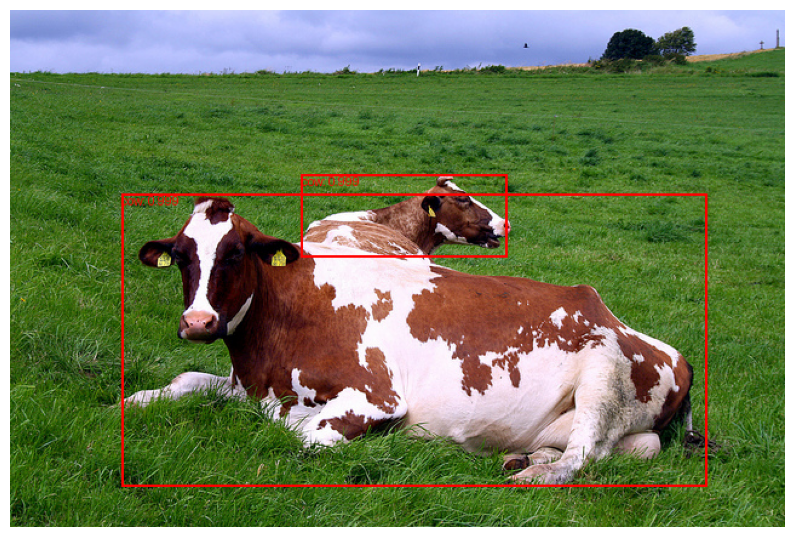

In [ ]:


# Load the fine-tuned model and processor
model = DetrForObjectDetection.from_pretrained("detr_finetuned_coco")
processor = AutoImageProcessor.from_pretrained("detr_finetuned_coco")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


image_path = "/home/utn/firi22ka/Desktop/jenga/mlp/g10/datasets/test2017/000000000019.jpg"  # Change this to your test image path
image = Image.open(image_path).convert("RGB")


inputs = processor(images=image, return_tensors="pt")
inputs = {k: v.to(device) for k, v in inputs.items()}

# Run inference
with torch.no_grad():
    outputs = model(**inputs)

# Post-process the outputs (adjust the threshold as needed)
results = processor.post_process_object_detection(outputs, threshold=0.9, target_sizes=[image.size[::-1]])
result = results[0]

# Drawing bounding boxes and labels on the image
draw = ImageDraw.Draw(image)
for score, label, box in zip(result["scores"], result["labels"], result["boxes"]):
    # Convert box coordinates to a list of rounded numbers
    box = [round(i, 2) for i in box.tolist()]
    draw.rectangle(box, outline="red", width=2)
    label_text = f"{model.config.id2label[label.item()]}: {round(score.item(), 3)}"
    draw.text((box[0], box[1]), label_text, fill="red")

# Display the image with detections
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis("off")
plt.show()


In [16]:


# Load the fine-tuned model
model = DetrForObjectDetection.from_pretrained('/home/utn/firi22ka/Desktop/jenga/mlp/g10/test/detr_finetuned_coco')
processor = DetrImageProcessor.from_pretrained('/home/utn/firi22ka/Desktop/jenga/mlp/g10/test/detr_finetuned_coco')

# Set the model to evaluation mode
model.eval()


loading configuration file /home/utn/firi22ka/Desktop/jenga/mlp/g10/test/detr_finetuned_coco/config.json
Model config DetrConfig {
  "_name_or_path": "facebook/detr-resnet-50",
  "activation_dropout": 0.0,
  "activation_function": "relu",
  "architectures": [
    "DetrForObjectDetection"
  ],
  "attention_dropout": 0.0,
  "auxiliary_loss": false,
  "backbone": "resnet50",
  "backbone_config": null,
  "backbone_kwargs": {
    "in_chans": 3,
    "out_indices": [
      1,
      2,
      3,
      4
    ]
  },
  "bbox_cost": 5,
  "bbox_loss_coefficient": 5,
  "class_cost": 1,
  "classifier_dropout": 0.0,
  "d_model": 256,
  "decoder_attention_heads": 8,
  "decoder_ffn_dim": 2048,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 6,
  "dice_loss_coefficient": 1,
  "dilation": false,
  "dropout": 0.1,
  "encoder_attention_heads": 8,
  "encoder_ffn_dim": 2048,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 6,
  "eos_coefficient": 0.1,
  "giou_cost": 2,
  "giou_loss_coefficient": 2,
  "id2label"

DetrForObjectDetection(
  (model): DetrModel(
    (backbone): DetrConvModel(
      (conv_encoder): DetrConvEncoder(
        (model): FeatureListNet(
          (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
          (bn1): DetrFrozenBatchNorm2d()
          (act1): ReLU(inplace=True)
          (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          (layer1): Sequential(
            (0): Bottleneck(
              (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn1): DetrFrozenBatchNorm2d()
              (act1): ReLU(inplace=True)
              (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn2): DetrFrozenBatchNorm2d()
              (drop_block): Identity()
              (act2): ReLU(inplace=True)
              (aa): Identity()
              (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      

Uncomment and run below line if you face preprocessor_config.json is missing

In [ ]:
# image_processor = DetrImageProcessor.from_pretrained('facebook/detr-resnet-50')
# image_processor.save_pretrained('detr_finetuned_coco') # change this path to your model folder

# Freezing backbone and training only detection heads for 100 images


In [ ]:
main(
    subset_size=100,           #change subset size if needed
    batch_size=4,
    num_epochs=5,
    lr=1e-5,
    checkpoint="facebook/detr-resnet-50",
    freeze_backbone=True,      # Set to True to freeze backbone parameters
    num_workers=4,
    save_dir="detr_finetuned_coco_backbone_freeze_100"
)